# Sessa Empirical Estimator 🧪
## Overview & Journal Summary 📄
### The Sessa Empirical Estimator (SEE) 📊
Sometimes, it is difficult to track prescriptions especially when in the secondary data source there are missing or incomplete dosing details. This is where the SEE comes in. The SEE was introduced as a data-driven method for computing the duration of prescriptions from secondary data sources. The following are the main steps that SEE does.

1. **Compute Temporal Distances**: For each patient, calculate the time between consecutive prescription fills.
2. **Trim Outliers**: Use the empirical cumulative distribution function (ECDF) to remove the top 20% of these distances (which may be inflated by irregular refill patterns).
3. **Random Sampling & Standardization**: Randomly select pairs of consecutive fills, then standardize these temporal distances.
4. **Clustering**: Use k‑means clustering (with the optimal number of clusters determined, for example, via silhouette analysis) to group the standardized distances.
5. **Duration Estimation**: For each cluster, compute the median temporal distance to serve as the estimated “filled‐prescription duration.”

The journals we read had reports of high accuracy and sensitivity when validating the method on both simulated and real-world data. We will now try to replicate the R code of these journals into our Python implementations and then use a different clustering method for comparison and analysis of results.

## Importing the necessary libraries 📚
This step ensures all required libraries are available for data manipulation, visualization, and clustering.


In [ ]:
pip install numpy pandas scikit-learn matplotlib seaborn lifelines

In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale

warnings.filterwarnings('ignore')

## Converting R Code to Python 🔄
Below is a simplified Python implementation of the SEE method using common packages like pandas, numpy, and scikit-learn

### Simulating a Dataset 📊
In this step, we simulate patient prescription data. Each patient has a series of prescription fill dates, and we randomly assign each prescription to one of two medications (medA or medB). The resulting dataset is stored in a DataFrame called df, which contains columns for patient number (pnr), prescription fill date (eksd), and medication type (ATC).

In [19]:
#######################
# 1. Simulate Data
#######################
np.random.seed(42)

def simulate_patient_data(num_patients):
    rows_per_patient = np.random.randint(2, 30, size=num_patients)  # each patient has 2-9 events
    records = []
    for p in range(num_patients):
        pnr = p + 1
        # random starting date
        base_date = pd.Timestamp('2020-01-01') + pd.Timedelta(days=np.random.randint(0, 100))
        # create a series of 2-9 events
        dates = [base_date]
        for i in range(rows_per_patient[p] - 1):
            gap_days = np.random.randint(10, 60)  # random interval
            new_date = dates[-1] + pd.Timedelta(days=gap_days)
            dates.append(new_date)
        for d in dates:
            records.append((pnr, d))
    return records

# Simulate data for 100 patients
records_set = simulate_patient_data(100)

# Create a single dataframe
df = pd.DataFrame(records_set, columns=['pnr', 'eksd'])
df = df.sort_values(by=['pnr', 'eksd']).reset_index(drop=True)

# Randomly assign each row to either 'medA' or 'medB'
df['ATC'] = np.random.choice(['medA', 'medB'], size=len(df))

# Print the records for verification
print("Records Set:")
print(df)

Records Set:
      pnr       eksd   ATC
0       1 2020-03-02  medA
1       1 2020-04-20  medA
2       1 2020-05-20  medA
3       1 2020-06-14  medA
4       1 2020-08-07  medB
...   ...        ...   ...
1620  100 2022-02-17  medA
1621  100 2022-03-09  medB
1622  100 2022-04-28  medB
1623  100 2022-05-10  medA
1624  100 2022-06-16  medB

[1625 rows x 3 columns]


### Sessa Empirical Estimator Function 📐
The code defines the Sessa Empirical Estimator (SEE) function in Python using k-means clustering. Here are the steps it performs:

1. **Filter by ATC Code**: The function filters the dataset to include only the rows corresponding to the specified ATC code (default is 'medA').

2. **Sort and Compute Event Intervals**: The filtered data is sorted by patient number (`pnr`) and prescription fill date (`eksd`). The time interval between consecutive prescription fills (`event.interval`) is calculated.

3. **Build Empirical Distribution**: The empirical cumulative distribution function (ECDF) of the event intervals is computed, and the top 20% of the intervals are removed to trim outliers.

4. **K-means Clustering**: The remaining intervals are standardized and clustered using k-means clustering. The optimal number of clusters is determined using silhouette analysis.

5. **Cluster Statistics**: For each cluster, the minimum, maximum, and median event intervals are calculated.

6. **Map Cluster Statistics**: The cluster statistics are mapped back to the original dataset. For rows not included in the trimmed dataset, the median interval of the most frequent cluster is assigned.

7. **Return Final DataFrame**: The final DataFrame, including the cluster and median interval information, is returned.

In [ ]:
#######################
# 2. Define the "See" Function in Python
#######################
def See_py(data, atc_code='medA'):
    # Filter by ATC code
    df_sub = data[data['ATC'] == atc_code].copy()
    
    
    
    
    # Sort by pnr, eksd and compute event.interval
    df_sub = df_sub.sort_values(by=['pnr','eksd'])
    df_sub['prev_eksd'] = df_sub.groupby('pnr')['eksd'].shift(1)
    # drop rows where there's no previous date
    df_sub = df_sub.dropna(subset=['prev_eksd'])
    
    df_sub['event.interval'] = (df_sub['eksd'] - df_sub['prev_eksd']).dt.days.astype(float)
    
    
    
    
    # 2a. Build empirical distribution
    sorted_intervals = np.sort(df_sub['event.interval'].values)
    # compute empirical CDF
    cdf_vals = np.arange(1, len(sorted_intervals)+1) / len(sorted_intervals)
    
    
    
    
    # 2b. Keep intervals <= 80th percentile (top 20% truncated)
    cutoff_index = np.searchsorted(cdf_vals, 0.8)
    cutoff_value = sorted_intervals[cutoff_index] if cutoff_index < len(sorted_intervals) else sorted_intervals[-1]
    
    df_trunc = df_sub[df_sub['event.interval'] <= cutoff_value].copy()
    
    
    
    
    # 2c. K-means Clustering with Silhouette-based K selection
    # Truncating the top 20% of the intervals helps
    # We'll cluster log(event.interval)
    intervals_log = np.log(df_trunc['event.interval'].values.reshape(-1,1))
    # scale for numeric stability
    intervals_scaled = scale(intervals_log)
    
    possible_ks = range(2,6)  # try k=2 up to 5
    best_k = 2
    best_sil = -999
    
    for k in possible_ks:
        km = KMeans(n_clusters=k, random_state=123).fit(intervals_scaled)
        labels = km.labels_
        sil = silhouette_score(intervals_scaled, labels)
        if sil > best_sil:
            best_sil = sil
            best_k = k
    
    # run final K-means with best_k
    final_km = KMeans(n_clusters=best_k, random_state=123).fit(intervals_scaled)
    df_trunc['cluster'] = final_km.labels_
    
    
    
    
    
    # 2d. For each cluster, find min, max, median on the exponential scale
    # grouping is the way
    cluster_stats = df_trunc.groupby('cluster')['event.interval'].agg(['min','max','median']).reset_index()
    
    # Merge cluster stats back to the truncated df
    df_trunc = df_trunc.merge(cluster_stats, on='cluster', how='left', suffixes=('','_clust'))
    
    
    
    
    # 2e. Now map cluster stats to the entire original subset
    # For any row in the original subset not in df_trunc, we assign the "most frequent cluster's median"
    freq_cluster = df_trunc['cluster'].value_counts().idxmax()
    fallback_median = cluster_stats.loc[cluster_stats['cluster']==freq_cluster,'median'].values[0]
    
    # Merge cluster info back
    df_merged = df_sub.merge(df_trunc[['pnr','eksd','cluster','median']], on=['pnr','eksd'], how='left')
    
    # Fill missing cluster/median with fallback
    df_merged['cluster'] = df_merged['cluster'].fillna(-1)
    df_merged['median'] = df_merged['median'].fillna(fallback_median)
    
    # Return final
    return df_merged

### Visualization of the Clusters 📊

The `see_assumption_py` function visualizes the distribution of prescription durations for each patient using a boxplot. Here are the steps it performs:

1. **Sort and Compute Previous Prescription Date**:
    - The data is sorted by patient number (`pnr`) and prescription fill date (`eksd`). The previous prescription fill date (`prev_eksd`) for each patient is computed using the `shift(1)` method. Rows without a previous prescription date are dropped.

2. **Calculate Duration**:
    - The duration between consecutive prescription fills (`Duration`) is calculated in days.

3. **Create Sequence Index**:
    - Within each patient group, a sequence index (`P Number`) is created to represent the order of prescriptions.

4. **Boxplot Visualization**:
    - A boxplot is created to visualize the distribution of `Duration` for each `P Number`. The median of medians for the `Duration` across all patients is computed and displayed as a horizontal red dashed line on the boxplot.

5. **Plot Customization**:
    - The plot is customized with a title indicating the ATC code of the medication. The layout is adjusted for better visualization.

In [ ]:
#######################
# 3. "see_assumption" in Python: Boxplot of intervals vs. p_number
#######################
def see_assumption_py(data):
    # Sort by pnr, eksd and compute a 'p_number' index
    df_temp = data.copy()
    df_temp = df_temp.sort_values(by=['pnr','eksd'])
    df_temp['prev_eksd'] = df_temp.groupby('pnr')['eksd'].shift(1)
    df_temp.dropna(subset=['prev_eksd'], inplace=True)
    df_temp['Duration'] = (df_temp['eksd'] - df_temp['prev_eksd']).dt.days
    
    # Within each pnr, create a sequence
    df_temp['P Number'] = df_temp.groupby('pnr').cumcount() + 1
    print(df_temp)
    
    # Boxplot
    fig, ax = plt.subplots(figsize=(5,4))
    sns.boxplot(data=df_temp, x='P Number', y='Duration',ax=ax, color='gray')
    
    # Compute "median of medians"
    medians_of_medians = df_temp.groupby('pnr')['Duration'].median().median()
    
    # Horizontal red dashed line
    ax.axhline(medians_of_medians, color='red', linestyle='--')
    atc_code = data['ATC'].iloc[0]
    ax.set_title(f"Durations vs Patient Number for {atc_code}\nRed Dashed = Median of Medians")
    plt.tight_layout()
    plt.show()

### Testing the code 🚀

This code block calls two functions: `See_py(df)` and `see_assumption_py(df_clustered)`. The `See_py(df)` function applies the Sessa Empirical Estimator (SEE) method to the dataframe `df` using the default ATC code.


     pnr       eksd   ATC  prev_eksd  event.interval  cluster  median  \
1      1 2020-05-20  medA 2020-04-20            30.0      1.0    25.0   
2      1 2020-06-14  medA 2020-05-20            25.0      1.0    25.0   
3      1 2020-12-01  medA 2020-06-14           170.0     -1.0    56.0   
5      2 2020-06-12  medA 2020-04-23            50.0      0.0    56.0   
6      2 2020-07-20  medA 2020-06-12            38.0      0.0    56.0   
..   ...        ...   ...        ...             ...      ...     ...   
684  100 2021-08-24  medA 2021-06-29            56.0      0.0    56.0   
685  100 2021-10-15  medA 2021-08-24            52.0      0.0    56.0   
686  100 2021-11-20  medA 2021-10-15            36.0      1.0    25.0   
687  100 2022-02-17  medA 2021-11-20            89.0      0.0    56.0   
688  100 2022-05-10  medA 2022-02-17            82.0      0.0    56.0   

     Duration  P Number  
1          30         1  
2          25         2  
3         170         3  
5          50      

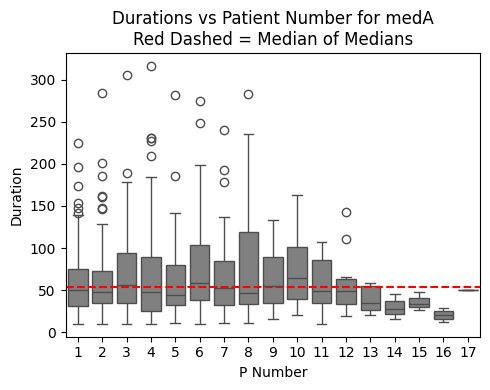

In [26]:
#######################
# 4.a Run the functions with medA
#######################
df_clustered = See_py(df)
see_assumption_py(df_clustered)

### Insights for medA SEE Results 📊
Based on the boxplot:
1. The first few p numbers show large spreads and high outliers with some going over the 150 day mark. This suggests that, at first, patients rarely go for in-between refills or started therapy late. 

2. The median of medians (red-dash line) shows that half the patient medians are below 50 days and the other half above. 

3. We can also see that as the p number increases, the plot trends lower, going below 60 days. This means that once a patient is on a stable medication schedule, they go for smaller intervals of refills.

4. From the third insight, we can also say that patients that reach p number 14 higher are refilling more consistently than those on the first numbers with fewer outliers.

     pnr       eksd   ATC  prev_eksd  event.interval  cluster  median  \
1      1 2020-10-29  medB 2020-09-03            56.0      0.0    54.0   
3      2 2020-10-16  medB 2020-10-06            10.0      1.0    21.0   
4      2 2020-11-19  medB 2020-10-16            34.0      0.0    54.0   
5      2 2020-12-23  medB 2020-11-19            34.0      0.0    54.0   
6      2 2021-01-25  medB 2020-12-23            33.0      1.0    21.0   
..   ...        ...   ...        ...             ...      ...     ...   
735  100 2021-10-28  medB 2021-09-27            31.0      1.0    21.0   
736  100 2022-01-05  medB 2021-10-28            69.0      0.0    54.0   
737  100 2022-03-09  medB 2022-01-05            63.0      0.0    54.0   
738  100 2022-04-28  medB 2022-03-09            50.0      0.0    54.0   
739  100 2022-06-16  medB 2022-04-28            49.0      0.0    54.0   

     Duration  P Number  
1          56         1  
3          10         1  
4          34         2  
5          34      

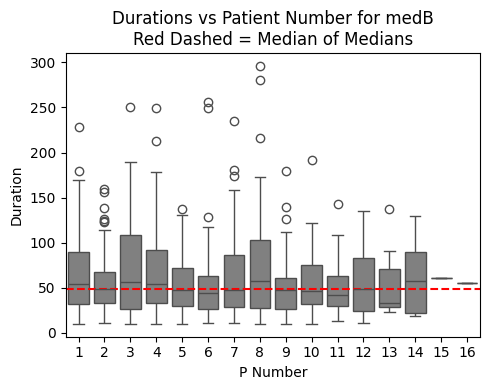

In [27]:
#######################
# 4.b Run the functions with medB
#######################

df_clustered = See_py(df, "medB")
see_assumption_py(df_clustered)

### Insights for medB SEE Results 📊
Based on the boxplot:
1. Like medA, the highest outliers (100–250 days) appear in the early p_numbers. These may be patients who waited an unusually long time for a second prescription or discontinued and then restarted after the gap.

2. The median of medians (red-dash line) shows to be around 50-55 days for the medB patients.

3. For many patients, intervals stabilize around 50–60 days as p_number increases. The red dashed line near 50–55 days confirms that a typical refill cycle for many medB users hovers around 7–8 weeks.

This pattern often reflects the reality that some patients start therapy irregularly but then settle into a more stable refill schedule over time.

## Insights for the Sessa K Means Model 📈
The data used in this clustering assignment was generated as a simulation for actual data from randomized seed of numbers. By combining SEE’s outlier truncation with K-means, you get robust “typical” intervals for each cluster, ignoring top-percentile gaps that might not reflect normal usage. 

In real-world pharmacoepidemiology, these clusters help define standard refill durations per patient or per cluster, improving the accuracy of treatment-episode construction.

    Overall, using SEE with K-means on these two datasets reveals distinct refill‐interval patterns and helps standardize durations for subsequent pharmacoepidemiological analyses—whether for computing adherence, defining treatment episodes, or identifying patients with potentially suboptimal medication use.

## Substituting K-Means with an Alternative Clustering Algorithm 🔄
K-means has well-known disadvantages—it assumes clusters are spherical, it needs to predetermine the number of clusters, and is very sensitive to outliers. To overcome these issues, you could try using DBSCAN, which can automatically identify the number of clusters and detect noise.

In [22]:
from sklearn.cluster import DBSCAN

# Use DBSCAN on the standardized data
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_db = dbscan.fit_predict(X)

# Filter out noise points (label = -1)
mask = labels_db != -1
X_db = X[mask]
labels_db = labels_db[mask]

# Create a DataFrame for DBSCAN results
db_df = pd.DataFrame({
    'days_diff': trimmed_diffs[mask],
    'cluster': labels_db
})

# Compute median durations for each DBSCAN cluster
db_cluster_medians = db_df.groupby('cluster')['days_diff'].median()
print("Median durations by DBSCAN cluster:")
print(db_cluster_medians)

# Visualize the clustering results
plt.scatter(X, np.zeros_like(X), c=labels_db, cmap='viridis')
plt.xlabel('Standardized Temporal Difference')
plt.title('DBSCAN Clustering of Temporal Differences')
plt.show()

NameError: name 'X' is not defined